<a href="https://colab.research.google.com/github/MohamedBechir361/Data_Science_Projects/blob/main/Electricity%20Price%20Forecast/Electricity_Price_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15-Day Electricity Price Forecasting with Ensemble and Meta-Learning

This project focuses on hourly forecasting of French wholesale electricity prices over a 15-day horizon, using a stacked ensemble of machine learning models.

The objective is to build a forecasting system that remains robust across calm and highly volatile market conditions, which is particularly challenging in electricity markets.

🔹 Approach highlights:
 * Ensemble of XGBoost, LightGBM, CatBoost and Ridge models
 * Hyperparameter optimization (Bayesian optimization for XGBoost, randomized search for other models)
 * Time-series cross-validation and out-of-fold stacking
 * Volatility- and regime-aware features (rolling statistics, weekly quantiles, seasonality)
 * Meta learner correcting individual model biases



## Initialisation

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import holidays
import shap

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, TimeSeriesSplit
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [ ]:
warnings.filterwarnings('ignore')

**Loading Datasets**

In this project, three open-source datasets are used to forecast electricity prices in France.

The first dataset consists of hourly wholesale electricity prices in France, covering the period from 1 January 2015 at 01:00 to 10 November 2025 at 10:00. These data are provided by Ember and are publicly available through the European Wholesale Electricity Price Database.

The second dataset includes weather and energy-related variables from the France Energy and Weather Data (hourly/daily) dataset available on Kaggle. It contains meteorological variables such as wind speed and direction, temperature, global solar irradiance, and cloud cover, as well as electricity consumption data. All variables are available at an hourly resolution for multiple regions across France.

The third dataset contains daily price data for GTT (Gaztransport & Technigaz) from 2023 to April 2024, obtained from ABC Bourse. GTT prices are used as a proxy for natural gas prices, as they are strongly correlated with gas market dynamics and therefore provide a reasonable approximation of underlying gas price trends.

The links for all datasets can be found at the end of this notebook.

In [ ]:
path_price = "/content/drive/MyDrive/Projet_forecast/France.csv"
prices = pd.read_csv(path_price)
prices = prices.drop(["Country",	"ISO3 Code",	"Datetime (UTC)"],axis=1)
prices["Datetime (Local)"] = pd.to_datetime(prices["Datetime (Local)"], format = '%Y-%m-%d %H:%M:%S')

"""# Ensure unique index before setting it
prices.drop_duplicates(subset=["Datetime (Local)"], keep="first", inplace=True)"""
prices.set_index("Datetime (Local)", inplace=True)

path_weather = "/content/drive/MyDrive/Projet_forecast/merged_hourly_regional.csv"
weather = pd.read_csv(path_weather)


In order to limit the dimensionality of the feature set, six regions were selected to represent the weather conditions across most of metropolitan France: West, North, Capital region, Center, Southeast, and Southwest. In addition, some of the available variables are not commonly used in electricity price forecasting. Therefore, only the most relevant meteorological and energy-related features were retained for the analysis.

In [ ]:
selected_regions = [11, 24, 44, 52, 75, 84]
selected_weather_features = [ "conso_elec_mw","temperature_2m","precipitation","cloud_cover","global_tilted_irradiance","wind_speed_100m","wind_direction_100m"]
weather = weather[['datetime_hour', 'insee_region']+ selected_weather_features]
weather = weather[weather['insee_region'].isin(selected_regions)]


In [ ]:
# Function to rename columns with region code

def add_region_suffix(df, features, region_col="region"):
    regions = df[region_col].unique()

    # Creating new column names for each feature per region
    new_columns = {}
    for feature in features:
        for region in regions:
            new_name = f"{feature}_{region}"
            new_columns[(feature, region)] = new_name

    transformed = df.pivot_table(index="datetime_hour", columns=region_col, values=features)

    transformed.columns = [f"{col}_{region}" for col, region in transformed.columns]

    return transformed.reset_index()

weather_transf = add_region_suffix(weather,selected_weather_features,region_col="insee_region")
weather_transf.head()

,datetime_hour,cloud_cover_11,cloud_cover_24,cloud_cover_44,cloud_cover_52,cloud_cover_75,cloud_cover_84,conso_elec_mw_11,conso_elec_mw_24,conso_elec_mw_44,conso_elec_mw_52,conso_elec_mw_75,conso_elec_mw_84,global_tilted_irradiance_11,global_tilted_irradiance_24,global_tilted_irradiance_44,global_tilted_irradiance_52,global_tilted_irradiance_75,global_tilted_irradiance_84,precipitation_11,precipitation_24,precipitation_44,precipitation_52,precipitation_75,precipitation_84,temperature_2m_11,temperature_2m_24,temperature_2m_44,temperature_2m_52,temperature_2m_75,temperature_2m_84,wind_direction_100m_11,wind_direction_100m_24,wind_direction_100m_44,wind_direction_100m_52,wind_direction_100m_75,wind_direction_100m_84,wind_speed_100m_11,wind_speed_100m_24,wind_speed_100m_44,wind_speed_100m_52,wind_speed_100m_75,wind_speed_100m_84
0,2013-01-01 00:00:00,100.0,100.0,87.0,100.0,100.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,1.6,0.0,1.5,1.2,0.0,8.2,9.6,4.7,9.1,8.3,7.0,207.0,220.0,198.0,213.0,195.0,188.0,41.7,34.0,29.6,48.9,28.7,37.8
1,2013-01-01 01:00:00,100.0,100.0,93.0,100.0,100.0,93.0,17956.0,4795.0,9754.0,6954.0,10886.0,16117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,1.3,0.0,1.3,1.1,0.0,8.0,9.5,4.5,8.8,8.5,6.9,208.0,225.0,199.0,217.0,201.0,188.0,41.7,29.5,30.1,46.6,30.8,37.4
2,2013-01-01 02:00:00,100.0,100.0,100.0,100.0,100.0,94.0,16728.0,4955.0,9737.0,6696.0,10957.0,15778.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.9,0.0,0.8,0.9,0.0,8.0,9.4,4.3,8.6,8.7,6.9,210.0,231.0,199.0,218.0,207.0,189.0,40.0,27.9,29.3,44.6,32.2,39.4
3,2013-01-01 03:00:00,100.0,100.0,100.0,100.0,100.0,97.0,15998.0,4677.0,9567.0,6095.0,10672.0,15618.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3,0.0,0.7,0.8,0.0,8.0,9.3,4.4,8.4,9.0,7.0,213.0,242.0,203.0,219.0,210.0,188.0,38.7,26.9,28.2,39.9,32.4,40.3
4,2013-01-01 04:00:00,100.0,97.0,98.0,100.0,100.0,99.0,15107.0,4223.0,9010.0,5490.0,9706.0,14944.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.2,0.0,0.5,0.9,0.0,8.0,9.1,4.6,8.2,9.4,7.0,216.0,250.0,202.0,220.0,215.0,188.0,38.4,28.8,29.1,34.8,32.1,40.3


In [ ]:
weather_transf['datetime_hour'] = pd.to_datetime(weather_transf['datetime_hour'])
# Ensure unique index before setting it
weather_transf.drop_duplicates(subset=["datetime_hour"], keep="first", inplace=True)
weather_transf = weather_transf.set_index("datetime_hour")
weather_train = weather_transf[weather_transf.index.year == 2023]
weather_test = weather_transf[(weather_transf.index.year == 2024) & (weather_transf.index.month == 1) & (weather_transf.index.day <= 15)]


In [ ]:
prices2023 = prices[prices.index.year == 2023]['Price (EUR/MWhe)']
y_test = prices[(prices.index.year == 2024) & (prices.index.month == 1) & (prices.index.day <= 15)]['Price (EUR/MWhe)']

### GTT Prices processing

The GTT price dataset is reported on a daily basis, with certain dates omitted, particularly during weekends. To construct a continuous time series, missing dates are initially imputed using the nearest available observation, such that Fridays and Saturdays share the same value, as do Sundays and Mondays. Subsequently, linear interpolation is applied between consecutive observations to produce an hourly time series, providing a consistent temporal resolution for the forecasting analysis.

In [ ]:
path_GTT = "/content/drive/MyDrive/Projet_forecast/GTT daily index 23_24.xlsx"
GTT = pd.read_excel(path_GTT)

In [ ]:
GTT.Date = pd.to_datetime(GTT.Date)
GTT.set_index("Date", inplace=True)
GTT.head()

,Ouverture,Plus Haut,Plus Bas,Volume,Dernier,Variation
Date,,,,,,
2023-01-02,100.90,101.30,99.60,39 715,99.65,0.0000
2023-01-03,96.00,98.45,92.00,197 055,96.00,-0.0366
2023-01-04,96.85,96.90,93.10,174 178,93.30,-0.0281
2023-01-05,94.70,96.25,93.75,98 057,94.80,0.0161
2023-01-06,94.90,98.10,94.80,117 735,97.40,0.0274


In [ ]:
idx = pd.date_range('01-01-2023', '28-06-2024', freq ='D')
GTT = GTT.reindex(idx, method = 'nearest')

In [ ]:
GTT = GTT.resample('h').interpolate(method='linear')
GTT.head()

,Ouverture,Plus Haut,Plus Bas,Volume,Dernier,Variation
2023-01-01 00:00:00,100.9,101.3,99.6,39 715,99.65,0.0
2023-01-01 01:00:00,100.9,101.3,99.6,NaN,99.65,0.0
2023-01-01 02:00:00,100.9,101.3,99.6,NaN,99.65,0.0
2023-01-01 03:00:00,100.9,101.3,99.6,NaN,99.65,0.0
2023-01-01 04:00:00,100.9,101.3,99.6,NaN,99.65,0.0


In [ ]:
GTT.drop(columns=['Volume'], inplace= True)

In [ ]:
GTT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13057 entries, 2023-01-01 00:00:00 to 2024-06-28 00:00:00
Freq: h
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ouverture  13057 non-null  float64
 1   Plus Haut  13057 non-null  float64
 2   Plus Bas   13057 non-null  float64
 3   Dernier    13057 non-null  float64
 4   Variation  13057 non-null  float64
dtypes: float64(5)
memory usage: 612.0 KB


In [ ]:
display(GTT.head())

,Ouverture,Plus Haut,Plus Bas,Dernier,Variation
2023-01-01 00:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 01:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 02:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 03:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 04:00:00,100.9,101.3,99.6,99.65,0.0


## Seasonal Features

### Fourier Features

Plotting the hourly electricity prices for each day in the 2023 training set reveals a clear bi-daily seasonality, with two recurring peaks occurring around 8:00 AM and 7:00 PM, with a variability of approximately ±1 hour. To further investigate the underlying periodicities, a spectrogram analysis is performed, which allows the identification of distinct frequency components present in the data. Based on these observations, we construct Fourier features—both sine and cosine terms—at different frequencies to capture these seasonal patterns. Specifically, features corresponding to yearly, weekly, and daily cycles are initially included to account for the dominant seasonalities in the dataset.

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


<Axes: title={'center': 'Seasonal Plot (day/hour)'}, xlabel='hour', ylabel='Price (EUR/MWhe)'>

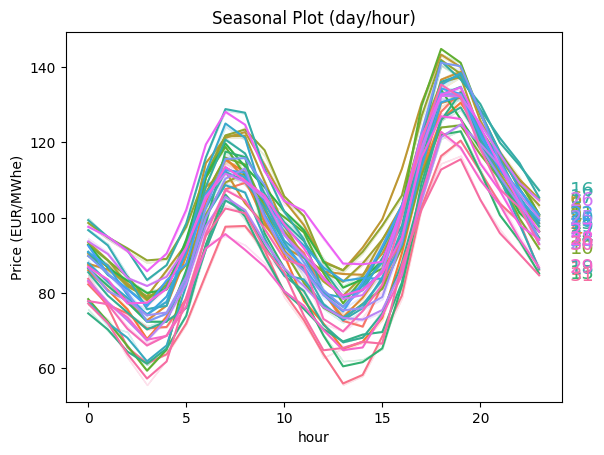

In [ ]:
df = pd.DataFrame(prices2023)
df.index = weather_train.index
df["day"] = df.index.day
df["hour"] = df.index.hour
seasonal_plot(df, "Price (EUR/MWhe)", "day", "hour", ax=None)

In [ ]:
y = prices2023.copy()
y.index = weather_train.index
y_test.index = weather_test.index

In [ ]:
fourier = CalendarFourier(freq = "YE", order = 12) # YE is stead of A
fourier_D = CalendarFourier(freq = "D", order = 6)
fourier_W = CalendarFourier(freq = "W", order = 6)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    seasonal = False,
    additional_terms = [fourier, fourier_D,fourier_W],
    drop=True,
)
X = dp.in_sample()

fore_period = 24*(3*30 + 15)
forecast_index = pd.date_range(
    start = y.index[-1] + pd.Timedelta(hours=1),
    periods = fore_period,
    freq = "h",
)

X_test_aux = dp.out_of_sample(steps = fore_period, forecast_index = forecast_index)

In [ ]:
X = pd.concat([X, X_test_aux], axis = 0)

### Calandar Features

Calendar features are also crucial for the model, particularly variables such as the hour of the day and the month. Additionally, interaction features were created—for instance, by multiplying the hour of the day by the day of the week—to capture potential combined effects and dependencies between temporal components.

In [ ]:
X['hour'] = X.index.hour
X['dayofweek'] = X.index.dayofweek
X['day'] = X.index.day
X['month'] = X.index.month
X['hourxdayofweek'] = X['hour'] * X['dayofweek']
X['hourxday'] = X['hour'] * X['day']

fr_holidays_23 = holidays.France(years=[2023])
fr_holidays_24 = holidays.France(years=[2024])

X["is_holiday"] = np.isin(X.index.date, list(fr_holidays_23.keys()) + list(fr_holidays_24.keys()) ).astype(int)

X['is_weekend'] = (X.index.dayofweek >= 5).astype(int)


In [ ]:
is_weekend_X = X.index.dayofweek >= 5

# multiplier toutes les colonnes Fourier journalières par is_weekend pour créer interaction
fourier_day_cols = [c for c in X.columns if 'D_' in c]
for col in fourier_day_cols:
    X[f"{col}_wkend"] = X[col] * is_weekend_X.astype(int)

peak_hours_morning = [7,8,9]
peak_hours_evening = [18,19,20]

X['peak_morning'] = (X.index.hour.isin(peak_hours_morning)).astype(int)
X['peak_evening'] = (X.index.hour.isin(peak_hours_evening)).astype(int)

In [ ]:
X = X.merge(GTT.Ouverture, how ='inner', left_index=True, right_index=True)
X = X.merge(weather_transf, how='inner', left_index=True, right_index=True)
X.head()

,const,trend,trend_squared,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(5,freq=YE-DEC)","cos(5,freq=YE-DEC)","sin(6,freq=YE-DEC)","cos(6,freq=YE-DEC)","sin(7,freq=YE-DEC)","cos(7,freq=YE-DEC)","sin(8,freq=YE-DEC)","cos(8,freq=YE-DEC)","sin(9,freq=YE-DEC)","cos(9,freq=YE-DEC)","sin(10,freq=YE-DEC)","cos(10,freq=YE-DEC)","sin(11,freq=YE-DEC)","cos(11,freq=YE-DEC)","sin(12,freq=YE-DEC)","cos(12,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)","sin(3,freq=D)","cos(3,freq=D)","sin(4,freq=D)","cos(4,freq=D)","sin(5,freq=D)","cos(5,freq=D)","sin(6,freq=D)","cos(6,freq=D)","sin(1,freq=W-SUN)",...,cloud_cover_44,cloud_cover_52,cloud_cover_75,cloud_cover_84,conso_elec_mw_11,conso_elec_mw_24,conso_elec_mw_44,conso_elec_mw_52,conso_elec_mw_75,conso_elec_mw_84,global_tilted_irradiance_11,global_tilted_irradiance_24,global_tilted_irradiance_44,global_tilted_irradiance_52,global_tilted_irradiance_75,global_tilted_irradiance_84,precipitation_11,precipitation_24,precipitation_44,precipitation_52,precipitation_75,precipitation_84,temperature_2m_11,temperature_2m_24,temperature_2m_44,temperature_2m_52,temperature_2m_75,temperature_2m_84,wind_direction_100m_11,wind_direction_100m_24,wind_direction_100m_44,wind_direction_100m_52,wind_direction_100m_75,wind_direction_100m_84,wind_speed_100m_11,wind_speed_100m_24,wind_speed_100m_44,wind_speed_100m_52,wind_speed_100m_75,wind_speed_100m_84
2023-01-01 00:00:00,1.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,-0.781831,...,94.0,100.0,57.0,80.0,13867.0,3829.0,6565.0,6176.0,9235.0,11483.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.2,0.0,0.0,14.8,14.4,11.8,15.0,13.8,14.0,204.0,211.0,189.0,211.0,178.0,192.0,48.8,53.2,35.7,52.7,34.9,40.8
2023-01-01 01:00:00,1.0,2.0,4.0,0.000717,1.000000,0.001435,0.999999,0.002152,0.999998,0.002869,0.999996,0.003586,0.999994,0.004304,0.999991,0.005021,0.999987,0.005738,0.999984,0.006455,0.999979,0.007173,0.999974,0.007890,0.999969,0.008607,0.999963,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,-0.757972,...,81.0,100.0,61.0,6.0,13051.0,3945.0,7465.0,5932.0,7739.0,12057.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.9,0.0,0.0,15.2,13.9,11.7,13.7,13.5,13.8,213.0,216.0,188.0,211.0,183.0,188.0,49.4,49.8,36.0,54.9,34.2,41.8
2023-01-01 02:00:00,1.0,3.0,9.0,0.001435,0.999999,0.002869,0.999996,0.004304,0.999991,0.005738,0.999984,0.007173,0.999974,0.008607,0.999963,0.010041,0.999950,0.011476,0.999934,0.012910,0.999917,0.014345,0.999897,0.015779,0.999876,0.017213,0.999852,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.733052,...,95.0,100.0,22.0,20.0,12450.0,3769.0,8185.0,5636.0,7731.0,12332.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,15.1,14.4,11.9,13.5,15.3,13.7,215.0,218.0,193.0,210.0,196.0,187.0,46.0,52.9,40.3,55.5,36.0,44.6
2023-01-01 03:00:00,1.0,4.0,16.0,0.002152,0.999998,0.004304,0.999991,0.006455,0.999979,0.008607,0.999963,0.010759,0.999942,0.012910,0.999917,0.015062,0.999887,0.017213,0.999852,0.019365,0.999812,0.021516,0.999769,0.023667,0.999720,0.025818,0.999667,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,...,0.0,100.0,50.0,4.0,11702.0,3262.0,7917.0,5083.0,7029.0,12565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,15.2,13.9,12.1,14.1,15.1,13.6,213.0,221.0,194.0,217.0,200.0,191.0,42.4,46.0,38.5,55.2,34.2,43.6
2023-01-01 04:00:00,1.0,5.0,25.0,0.002869,0.999996,0.005

### Lag-based Features

In [ ]:
X.columns = [c.replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '_').replace('-', '_') for c in X.columns]

In [ ]:
X_full = X.copy()
mask23 = (prices.index.year == 2023)
mask24 = (prices.index.year == 2024) & (prices.index <= "2024-04-15 00:00:00")
y_full = prices[mask23 | mask24]['Price (EUR/MWhe)']
y_full.index = X.index # to correct the duplicated dates !

Examining the Partial Autocorrelation plot, we observe a strong correlation with prior values, particularly at lag 1, but also across most of the previous 24 hours.

To better capture the data’s variability, we will include additional features such as the 12-hour and 24-hour rolling means and standard deviations. We will also create features that reflect relative changes in prices (e.g., between hours h-2 and h-1) and identify sudden spikes using the Z-score.

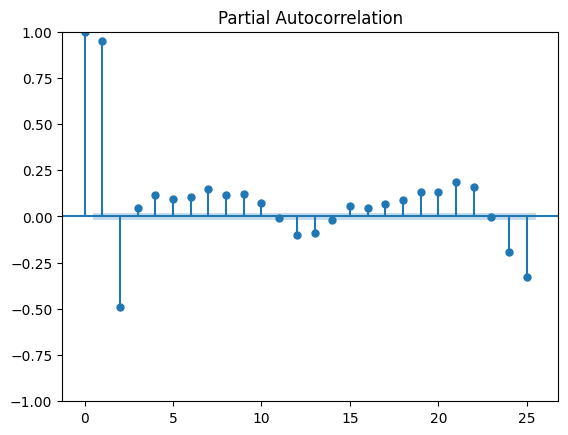

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y, lags=25);

In [ ]:
X_full["24h_mean"] = y_full.shift(1).rolling(window=24, center = False).mean()
X_full["12h_mean"] = y_full.shift(1).rolling(window=12, center = False).mean()
X_full["24h_std"] = y_full.shift(1).rolling(window=24, center = False).std()
X_full["12h_std"] = y_full.shift(1).rolling(window=12, center = False).std()

for i in range(1, 25) :
  X_full[f"lag_{i}"] = y_full.shift(i)


In [ ]:
X_full["price_change"] = y_full.shift(1).diff()

In [ ]:
X_full["price_zscore"] = (y_full.shift(1) - X_full["24h_mean"]) / X_full["24h_std"]
X_full["z_spike"] = (X_full["price_zscore"].abs() > 3).astype(int)

In [ ]:
X_full["spike_intensity"] = X_full["price_zscore"].abs()

In [ ]:
window = 168

q168_10 = y_full.shift(1).rolling(window).quantile(0.10)
q168_50 = y_full.shift(1).rolling(window).quantile(0.50)
q168_90 = y_full.shift(1).rolling(window).quantile(0.90)

iqr168 = q168_90 - q168_10

In [ ]:
X_full["q168_10"] = q168_10
X_full["q168_50"] = q168_50
X_full["iqr168"] = iqr168

In [ ]:
X_full.dropna(inplace = True, axis = 0)

# A single Model approach

**Initial XGBoost Model**

We will start by an XGBoost model using randomly chosen parameters, then we will use bayesian optimization for hypertuning the model.

In [ ]:
{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 700, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

{'subsample': 1.0,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'num_leaves': 15,
 'n_estimators': 700,
 'min_child_samples': 20,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 1.0}

We will divide in two steps to create training, test (or validation), and the forecast set.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full[window:], test_size=fore_period/len(X_full), shuffle = False)

In [ ]:
X_test, X_fore, y_test, y_fore = train_test_split(X_test, y_test, test_size=15*24/len(X_test), shuffle = False)

In [ ]:
model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    subsample = 1.0,
    reg_lambda = 0.1,
    reg_alpha = 0.1,
    n_estimators = 700,
    max_depth = 3,
    learning_rate = 0.01,
    colsample_bytree = 1.0
)
model.fit(X_train,y_train)
y_pred = pd.Series(model.predict(X_train))

In [ ]:
fig = go.Figure()

# Add trace for prices
fig.add_trace(go.Scatter(x=X_train.index, y = y_train, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_train.index, y = y_pred, mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices in 2023',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

In [ ]:
r2 = r2_score(y_train, y_pred)
print("R² = ", r2)

R² =  0.9628603733796953


In [ ]:
y_hat = pd.Series(model.predict(X_test))
y_hat.index = X_test.index

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y = y_test, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_test.index, y = y_hat , mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices from 1st to 15th of january 2024',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

In [ ]:
error = mean_absolute_error(y_test, y_hat)
error

5.550696717723307

In [ ]:
r2 = r2_score(y_test, y_hat)
print("R² = ", r2)

R² =  0.9121520671885628


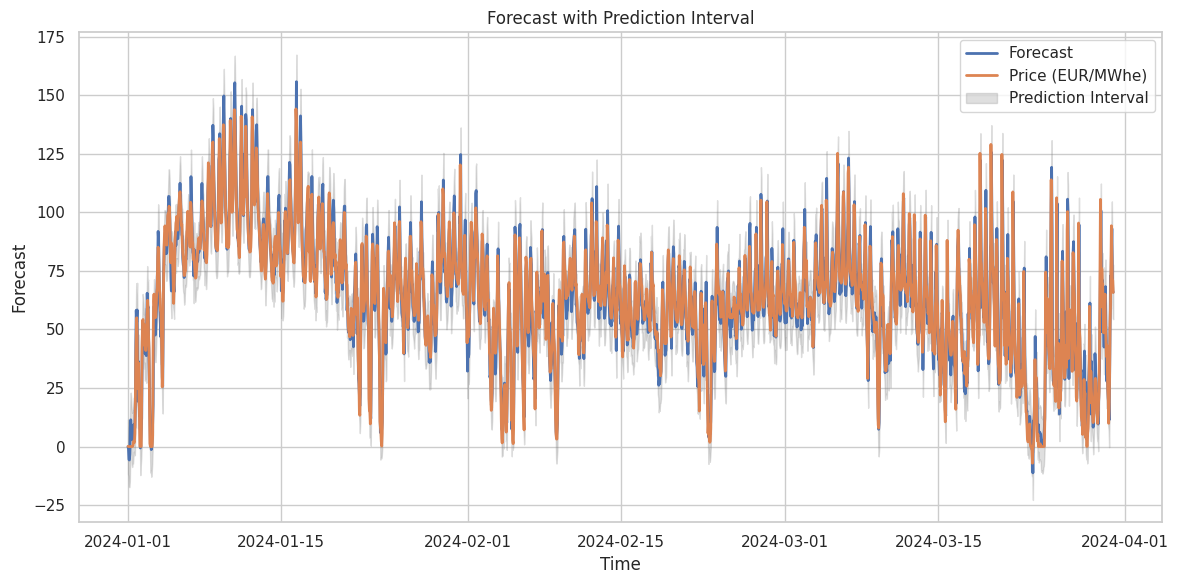

In [ ]:
residuals = np.abs(y_test - y_hat)
q = np.quantile(residuals, 0.9)
lower = y_hat - q
upper = y_hat + q

# Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Main forecast line
plt.plot(y_hat.index, y_hat, label="Forecast", linewidth=2)
plt.plot(X_test.index, y_test, label='Price (EUR/MWhe)', linewidth=2)

# Prediction interval (transparent gray)
plt.fill_between(
    y_hat.index, lower, upper,
    color="gray", alpha=0.25,
    label="Prediction Interval"
)

plt.xlabel("Time")
plt.ylabel("Forecast")
plt.title("Forecast with Prediction Interval")
plt.legend()
plt.tight_layout()
plt.show()


# Improvements

### Hyperparameters tunining using Bayesian Optmization

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
        "random_state": 42,
        "objective": "reg:squarederror"
    }

    model = XGBRegressor(**params)

    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_train2, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train2, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train2, y_train2)
        preds = model.predict(X_val)
        scores.append(mean_squared_error(y_val, preds))

    return -np.mean(scores)  # maximize negative MSE

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best CV score:", study.best_value)

[I 2025-12-22 22:40:31,290] A new study created in memory with name: no-name-d848b263-8dd1-4c45-aae5-1e08158dfcd4
[I 2025-12-22 22:41:28,996] Trial 0 finished with value: -8.116322664622137 and parameters: {'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.07230327157333478, 'subsample': 0.758677687568115, 'colsample_bytree': 0.9042338981299457, 'reg_alpha': 0.7413435021844106, 'reg_lambda': 1.9673733553643866}. Best is trial 0 with value: -8.116322664622137.
[I 2025-12-22 22:43:36,593] Trial 1 finished with value: -38.231333427581816 and parameters: {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.057993776291087824, 'subsample': 0.965543280870675, 'colsample_bytree': 0.646262629299553, 'reg_alpha': 0.47933617921999905, 'reg_lambda': 8.779106457557251}. Best is trial 0 with value: -8.116322664622137.
[I 2025-12-22 22:45:35,188] Trial 2 finished with value: -15.1743519957123 and parameters: {'n_estimators': 151, 'max_depth': 10, 'learning_rate': 0.07389145397356793, 'subs

Best parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.05984896527253327, 'subsample': 0.6903254664045922, 'colsample_bytree': 0.971990411708081, 'reg_alpha': 7.4080537576088545, 'reg_lambda': 2.506167152809447}
Best CV score: -5.154131370187199


In [ ]:
Best_parameters = study.best_params

### Random Search Hypertuning for LightLGB model

In [ ]:
param_grid = {
    "num_leaves":        [7, 15, 31],   # shallow trees
    "max_depth":         [3, 4, 5],
    "learning_rate":     [0.005, 0.01, 0.05, 0.1],
    "n_estimators":      [300, 500, 700, 900],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    "reg_alpha":         [0.0, 0.1, 0.5],
    "reg_lambda":        [0.1, 1.0, 2.0],
    "min_child_samples": [10, 20, 40],
}


In [ ]:
# Sanitize column names for LightGBM compatibility
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

X_train_lgb.columns = [c.replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '_').replace('-', '_') for c in X_train_lgb.columns]
X_test_lgb.columns = [c.replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '_').replace('-', '_') for c in X_test_lgb.columns]


In [ ]:

# shallow depth baseline model
lgbm = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    verbosity=-1
)

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    scoring="neg_mean_absolute_error",
    n_iter=40,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_lgb, y_train)

best_params_lgb = search.best_params_

print("Best params:", search.best_params_)
print("Best MAE:", -search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 7, 'n_estimators': 700, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best MAE: 7.631381925680222


In [ ]:
best_model_lgb = lgb.LGBMRegressor(**best_params_lgb)
best_model_lgb.fit(X_train_lgb, y_train)
y_pred_lgb = pd.Series(best_model_lgb.predict(X_test_lgb))
y_pred_lgb.index = X_test.index

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26360
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 139
[LightGBM] [Info] Start training from score 97.088086


In [ ]:
model_lgb = lgb.LGBMRegressor(
    max_depth=5,                  # forces smoothness
    learning_rate=0.1,
    n_estimators=300,
    subsample = 0.6,
    reg_lambda =0.1,
    reg_alpha = 0.0,
    num_leaves = 31,
    min_child_samples = 40,
    colsample_bytree = 0.6
)

model_lgb.fit(X_train_lgb, y_train)
y_pred_lgb = pd.Series(model_lgb.predict(X_test_lgb))
y_pred_lgb.index = X_test.index

In [ ]:
r2 = r2_score(y_test, y_pred_lgb)
print("R² = ", r2)

R² =  0.9085714047348874


### Optimized Parameters

In [ ]:
Best_parameters = {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.05984896527253327,
                   'subsample': 0.6903254664045922, 'colsample_bytree': 0.971990411708081,
                   'reg_alpha': 7.4080537576088545, 'reg_lambda': 2.506167152809447}

In [ ]:
best_params_lgb = {'subsample': 0.8,
                   'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 7,
                   'n_estimators': 700, 'min_child_samples': 20, 'max_depth': 5,
                   'learning_rate': 0.01, 'colsample_bytree': 1.0}


### Best Model

In [ ]:
best_model_xgb = XGBRegressor(**Best_parameters)
best_model_xgb.fit(X_train, y_train)
y_pred = pd.Series(best_model_xgb.predict(X_train))

In [ ]:
fig = go.Figure()

# Add trace for prices
fig.add_trace(go.Scatter(x=X_train.index, y = y_train, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_train.index, y = y_pred, mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices in 2023',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

In [ ]:
y_hat = pd.Series(best_model_xgb.predict(X_test))
y_hat.index = X_test.index

In [ ]:
r2 = r2_score(y_train, y_pred)
print("R² = ", r2)

R² =  0.9702092123279523


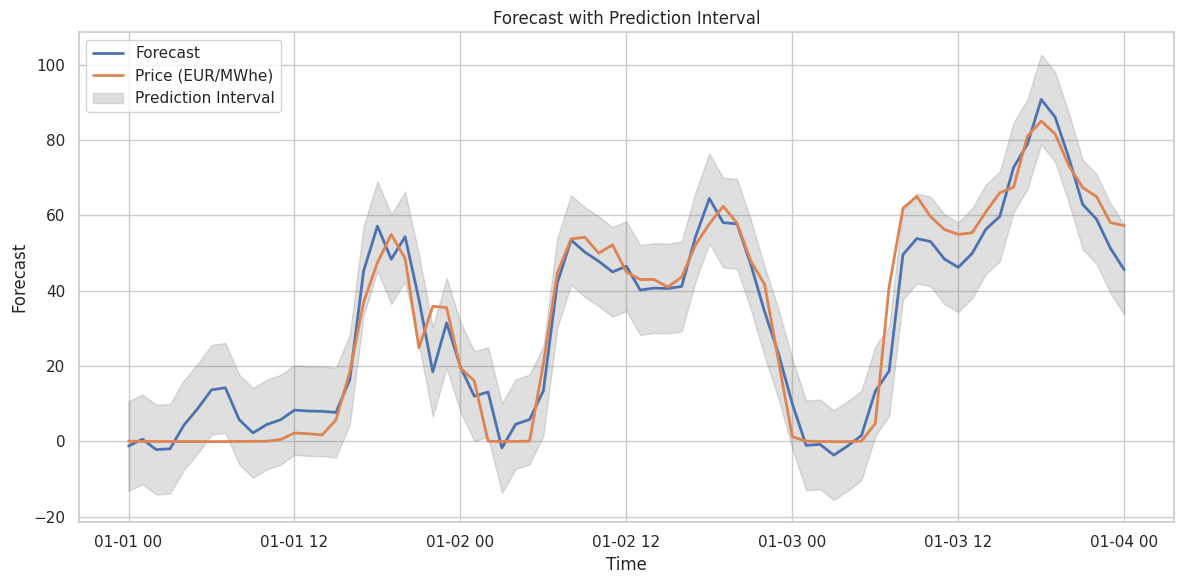

In [ ]:
residuals = np.abs(y_test - y_hat)
q = np.quantile(residuals, 0.9)
lower = y_hat - q
upper = y_hat + q

# Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Main forecast line
plt.plot(y_hat[:73].index, y_hat[:73], label="Forecast", linewidth=2)
#plt.plot(y_hat[:73].index, y_pred_lgb[:73], label="Forecast 2", linewidth=2)
plt.plot(X_test[:73].index, y_test[:73], label='Price (EUR/MWhe)', linewidth=2)

# Prediction interval (transparent gray)
plt.fill_between(
    y_hat[:73].index, lower[:73], upper[:73],
    color="gray", alpha=0.25,
    label="Prediction Interval"
)

plt.xlabel("Time")
plt.ylabel("Forecast")
plt.title("Forecast with Prediction Interval")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
error = mean_absolute_error(y_test, y_hat)
error

5.752144368947931

### Model Explainability and Linear Regression

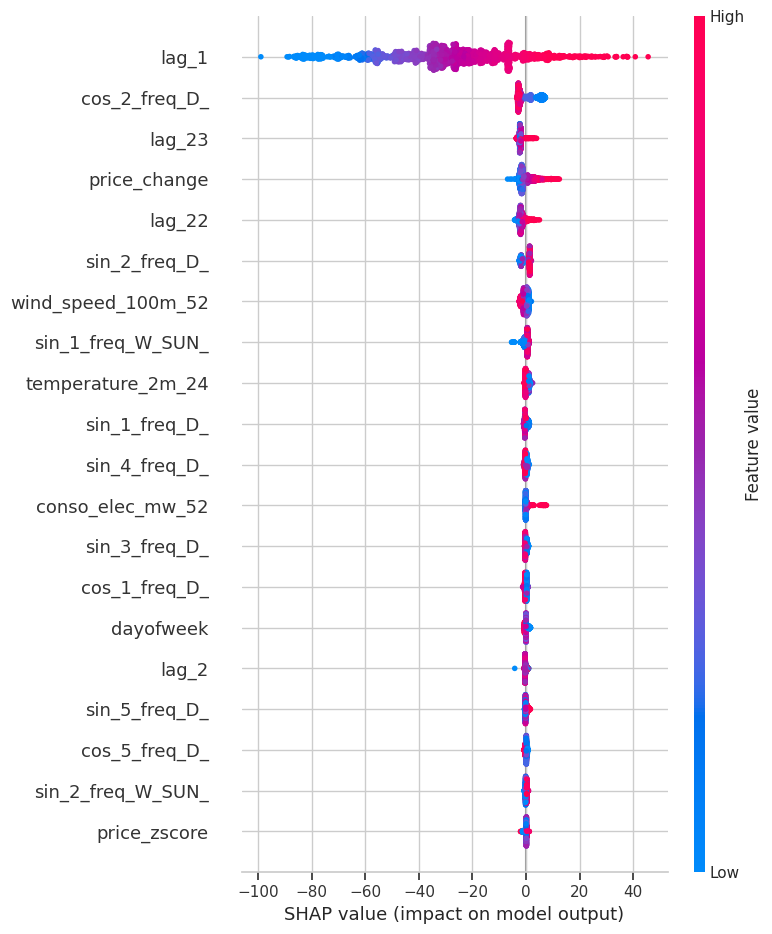

In [ ]:
explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [ ]:
global_importance = np.abs(shap_values).mean(axis=0)
importance = pd.Series(global_importance, X_test.columns).sort_values(ascending=False)
display(importance.head(50))

,0
lag_1,31.367622
cos_2_freq_D_,3.114419
lag_23,2.202284
price_change,2.096525
lag_22,1.856070
sin_2_freq_D_,1.484770
wind_speed_100m_52,0.926892
sin_1_freq_W_SUN_,0.679701
temperature_2m_24,0.591228
sin_1_freq_D_,0.460990


In [ ]:
Xpl_features = importance.index[:10]
LinReg = LinearRegression()
LinReg.fit(X_train[Xpl_features], y_train)
y_pred_lreg = pd.Series(LinReg.predict(X_train[Xpl_features]))
r2 = r2_score(y_train, y_pred_lreg)
print("Train R² = ", r2)

y_hat_lreg = pd.Series(LinReg.predict(X_test[Xpl_features]))
r2 = r2_score(y_test, y_hat_lreg)
print("Test R² = ", r2)

Train R² =  0.9459623727431706
Test R² =  0.8983709406015451


In [ ]:
fig = go.Figure()

# Add trace for prices
fig.add_trace(go.Scatter(x=X_test.index, y = y_test, mode='lines', name='Prices (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_test.index, y = y_hat_lreg, mode='lines', name='Predictions'))

# Update layout
fig.update_layout(
    title='Predictions of Linear Regression on Top 10 Features',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

# Meta-learner from XGBoost + Lightgbm + CatBoost + Ridge

### Training Individual Models

In [ ]:
ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = pd.Series(ridge_model.predict(X_test))
y_pred_ridge.index = X_test.index

r2 = r2_score(y_test, y_pred_ridge)
print("R² = ", r2)

R² =  0.8876211596619339


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.9 MB/s eta 0:00:00


In [ ]:
cat = CatBoostRegressor(
    loss_function="RMSE",
    depth=4,
    learning_rate=0.05,
    iterations=600,
    l2_leaf_reg=5,
    subsample=0.7,
    random_strength=0.5,
    bagging_temperature=0.3,
    verbose=False,
)

cat.fit(X_train, y_train)
y_pred_cat = pd.Series(cat.predict(X_test))
y_pred_cat.index = X_test.index

In [ ]:
def check_stability(model, X, y, n_splits=5, model_name="model"):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for i, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        r2 = r2_score(y_val, y_pred)
        scores.append(r2)

        print(f"{model_name} | Fold {i} R² = {r2:.4f}")

    scores = np.array(scores)
    print(f"\n{model_name} | Mean R² = {scores.mean():.4f}")
    print(f"{model_name} | Std  R² = {scores.std():.4f}")

    return scores

#check_stability(cat, X_train, y_train, n_splits=5, model_name="CatBoost")

In [ ]:
# Sanitize column names for LightGBM compatibility
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

model_lgb = lgb.LGBMRegressor(
    max_depth=5,                  # forces smoothness
    learning_rate=0.1,
    n_estimators=300,
    subsample = 0.6,
    reg_lambda =0.1,
    reg_alpha = 0.0,
    num_leaves = 31,
    min_child_samples = 40,
    colsample_bytree = 0.6
)

model_lgb.fit(X_train_lgb, y_train)
y_pred_lgb = pd.Series(model_lgb.predict(X_test_lgb))
y_pred_lgb.index = X_test.index

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26106
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 137
[LightGBM] [Info] Start training from score 96.754406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### Meta Model

In [ ]:
meta_X = np.column_stack([y_hat,
                          y_pred_lgb,
                          y_pred_ridge,
                          y_pred_cat,
                          np.mean([y_hat, y_pred_lgb, y_pred_ridge, y_pred_cat], axis=0),
                          np.std([y_hat, y_pred_lgb, y_pred_ridge, y_pred_cat], axis=0),
                          y_test.index.hour,
                          X_test['iqr168'],
                          X_test['24h_std'],
                          X_test['12h_std'],
                          X_test['24h_mean'],
                          X_test['12h_mean']
                          ])
meta_y = y_test

In [ ]:
meta_model = Ridge(alpha = 50.0)
meta_model.fit(meta_X, meta_y)

Ridge(alpha=50.0)

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    meta_model,
    meta_X, meta_y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))


In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    meta_model,
    meta_X, meta_y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

In [ ]:
new_train, new_y = pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0)
best_model_xgb.fit(new_train, new_y)
y_pred_xgb2 = pd.Series(best_model_xgb.predict(new_train))

In [ ]:
cat.fit(new_train, new_y)
y_pred_cat2 = pd.Series(cat.predict(new_train))

In [ ]:
ridge_model.fit(new_train, new_y)
y_pred_ridge2 = pd.Series(ridge_model.predict(new_train))

In [ ]:
new_train_lgb = new_train.copy()
new_y_lgb = new_y.copy()

best_model_lgb = lgb.LGBMRegressor(**best_params_lgb)
best_model_lgb.fit(new_train_lgb, new_y_lgb)
y_pred_lgb2 = pd.Series(best_model_lgb.predict(new_train_lgb))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26124
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 138
[LightGBM] [Info] Start training from score 90.048106


In [ ]:
meta_model.coef_

array([-0.14049525,  0.19554231,  0.11655849,  0.54916706,  0.18019315,
        0.3263905 ,  0.05248408,  0.01475675, -0.07369836, -0.05310247,
        0.02498607,  0.04487197])

In [ ]:
r2_score(meta_model.predict(meta_X), meta_y)

0.9204625650109617

In [ ]:
f_pred_xgb = best_model_xgb.predict(X_fore)
f_pred_lgb = best_model_lgb.predict(X_fore)
f_pred_ridge = ridge_model.predict(X_fore)
f_pred_cat = cat.predict(X_fore)

final_pred = pd.Series(meta_model.predict(
    np.column_stack([
        f_pred_xgb,
        f_pred_lgb,
        f_pred_ridge,
        f_pred_cat,
        np.mean([f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat], axis=0),
        np.std([f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat], axis=0),
        y_fore.index.hour,
        X_fore['iqr168'],
        X_fore['24h_std'],
        X_fore['12h_std'],
        X_fore['24h_mean'],
        X_fore['24h_std'],
    ])
))

final_pred.index = X_fore.index


In [ ]:
r2_score(y_fore, final_pred)

0.7382357004635673

In [ ]:
results_df = pd.DataFrame()
train_preds = [y_pred_xgb2, y_pred_lgb2, y_pred_ridge2, y_pred_cat2]
predictions = [final_pred, f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat ]
results_df['Train_RMSE'] = [root_mean_squared_error(meta_y, meta_model.predict(meta_X))] + [root_mean_squared_error(new_y, pred) for pred in train_preds]
results_df['Test_RMSE'] = [root_mean_squared_error(y_fore, e) for e in predictions]
results_df['Train_MAE'] = [mean_absolute_error(meta_y, meta_model.predict(meta_X))] +[mean_absolute_error(new_y, pred) for pred in train_preds]
results_df['Test_MAE'] = [mean_absolute_error(y_fore, e) for e in predictions]

results_df.index = pd.Index(["Meta Model", "XGBOOST", "LIGHTGBM", "RIDGE","CATBOOST"])

In [ ]:
results_df

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
Meta Model,7.062475,9.812936,4.953192,6.790997
XGBOOST,7.671885,10.667928,5.390496,7.375572
LIGHTGBM,8.644849,10.614032,5.946767,7.256245
RIDGE,9.114241,10.870106,6.361252,7.878673
CATBOOST,7.332301,10.695584,5.182264,7.381645


In [ ]:
predictions = [final_pred, f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat ]
for e in predictions:
    print("RMSE : ", root_mean_squared_error(y_fore, e) , " MAE : ", mean_absolute_error(y_fore, e))

RMSE :  9.812936372962337  MAE :  6.790997124722899
RMSE :  10.667927635541467  MAE :  7.375572041051255
RMSE :  10.614031734526328  MAE :  7.256245272411942
RMSE :  10.87010568769621  MAE :  7.878673210927301
RMSE :  10.69558350128832  MAE :  7.3816448355383635


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_fore.index, y = y_fore, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_fore.index, y = final_pred , mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices from 1st to 15th of April 2024',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

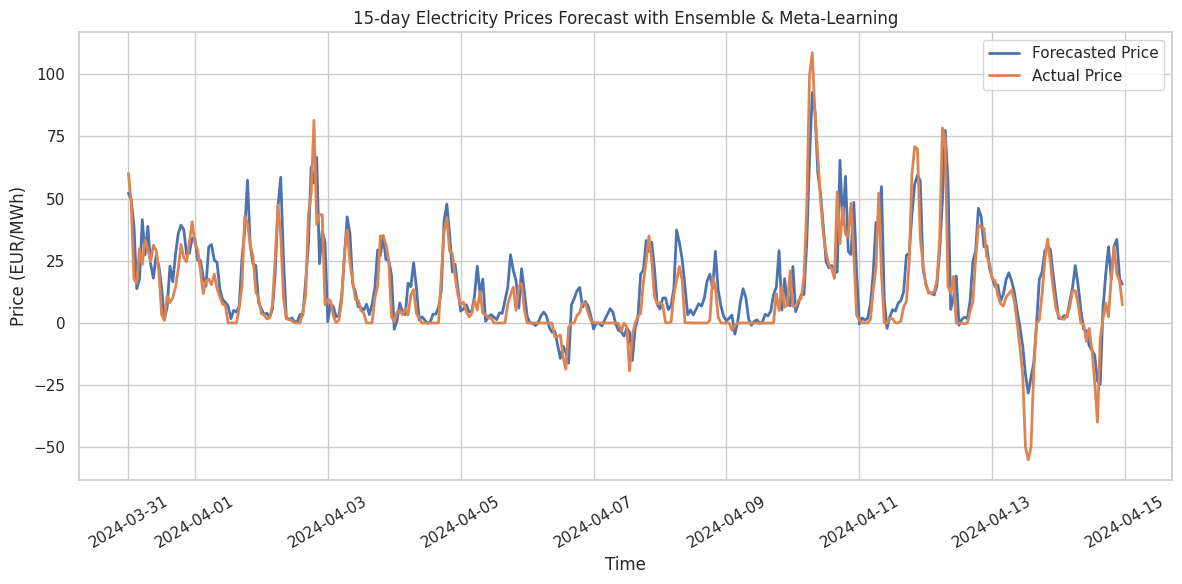

In [ ]:
# Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Main forecast line
plt.plot(y_fore.index, final_pred, label="Forecasted Price", linewidth=2)
plt.plot(X_fore.index, y_fore, label='Actual Price', linewidth=2)
plt.xticks(rotation=30)
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWh)")
plt.title("15-day Electricity Prices Forecast with Ensemble & Meta-Learning")
plt.legend()
plt.tight_layout()
plt.show()


**Usefull Links**

https://ember-energy.org/data/european-wholesale-electricity-price-data/

https://www.kaggle.com/datasets/ravvvvvvvvvvvv/france-energy-weather-hourly/data

https://www.abcbourse.com/graphes/eod/GTTp